In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
import os
#import xgboost as xgb
#import lightgbm as lgb
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import gc
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
data = pd.concat([train, test], axis=0)
print('Training data : {}'.format(len(train)))
print('Testing data : {}'.format(len(test)))
print('ALl columns : {}'.format(len(data.columns)))
print('ALl data : {}'.format(len(data)))

gc.collect()

Training data : 60000
Testing data : 10000
ALl columns : 235
ALl data : 70000


16

In [3]:
train.isna().sum().to_dict()

{'building_id': 0,
 'building_material': 0,
 'city': 0,
 'txn_dt': 0,
 'total_floor': 0,
 'building_type': 0,
 'building_use': 0,
 'building_complete_dt': 0,
 'parking_way': 0,
 'parking_area': 56897,
 'parking_price': 46065,
 'txn_floor': 15902,
 'land_area': 0,
 'building_area': 0,
 'town': 0,
 'lat': 0,
 'lon': 0,
 'village_income_median': 1142,
 'town_population': 0,
 'town_area': 0,
 'town_population_density': 0,
 'doc_rate': 0,
 'master_rate': 0,
 'bachelor_rate': 0,
 'jobschool_rate': 0,
 'highschool_rate': 0,
 'junior_rate': 0,
 'elementary_rate': 0,
 'born_rate': 0,
 'death_rate': 0,
 'marriage_rate': 0,
 'divorce_rate': 0,
 'village': 0,
 'N_50': 0,
 'N_500': 0,
 'N_1000': 0,
 'N_5000': 0,
 'N_10000': 0,
 'I_10': 0,
 'I_50': 0,
 'I_index_50': 0,
 'I_100': 0,
 'I_250': 0,
 'I_500': 0,
 'I_index_500': 0,
 'I_1000': 0,
 'I_index_1000': 0,
 'I_5000': 0,
 'I_index_5000': 0,
 'I_10000': 0,
 'I_index_10000': 0,
 'I_MIN': 0,
 'II_10': 0,
 'II_50': 0,
 'II_index_50': 0,
 'II_100': 0,


In [38]:
#Count train and test na number
miss_value_df =pd.concat([pd.DataFrame(train.isna().sum().to_dict(), index=['train']), pd.DataFrame(test.isna().sum().to_dict(), index=['test'])], axis=0)


# Total_price distribution

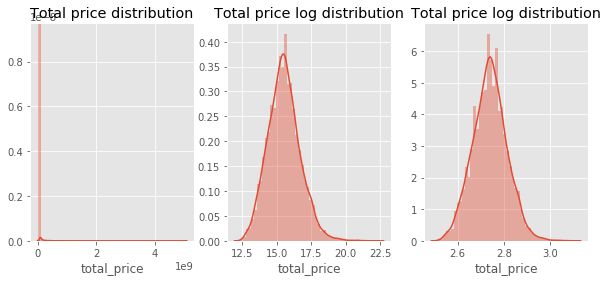

In [5]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,3,1)
ax.set_title('Total price distribution')
sns.distplot(train['total_price'])

ax = fig.add_subplot(1,3,2)
ax.set_title('Total price log distribution')
sns.distplot(np.log(train['total_price']))

ax = fig.add_subplot(1,3,3)
ax.set_title('Total price log distribution')
sns.distplot(np.log(np.log(train['total_price'])))

# Floor

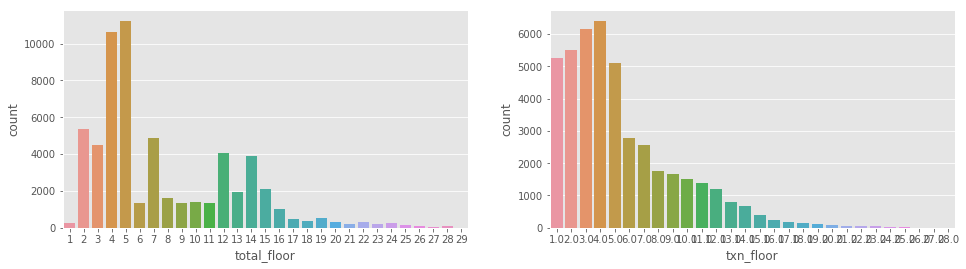

In [12]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(2,2,2)
sns.countplot(train['total_floor'])

ax = fig.add_subplot(1,2,2)
sns.countplot(train['txn_floor'])

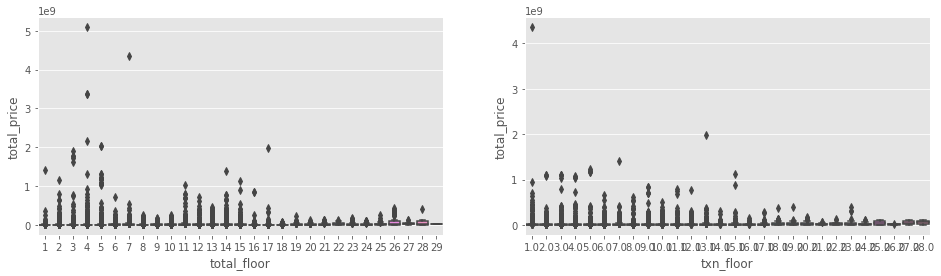

In [19]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
sns.boxplot(train['total_floor'], train['total_price'])

ax = fig.add_subplot(1,2,2)
sns.boxplot(train['txn_floor'], train['total_price'])


In [37]:
train.groupby(['building_type'])['total_floor'].count()

building_type
0    15691
1    15049
2     2822
3    10536
4    15902
Name: total_floor, dtype: int64

In [36]:
train.groupby(['building_type'])['txn_floor'].count()

building_type
0    15691
1    15049
2     2822
3    10536
4        0
Name: txn_floor, dtype: int64

In [40]:
miss_value_df

,III_10,III_100,III_1000,III_10000,III_250,III_50,III_500,III_5000,III_MIN,III_index_1000,...,total_floor,total_price,town,town_area,town_population,town_population_density,txn_dt,txn_floor,village,village_income_median
train,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,15902,0,1142
test,0,0,0,0,0,0,0,0,0,0,...,0,NaN,0,0,0,0,0,2639,0,184


In [45]:
miss_value_df.loc['train']['total_floor'], miss_value_df.loc['train']['txn_floor']
#4 maybe is a house not department

(0.0, 15902.0)

# City、town、village

In [48]:
train['city'].unique()

array([21,  7, 12, 17, 10, 13, 14,  3,  6,  5,  9])

In [49]:
train['town'].unique()

array([334, 180, 343, 102,   6,  84,  61,  49,  10, 158, 254, 196, 332,
       164, 211, 188, 330,  62, 179,  41,  29,  13,  15, 148, 273,  18,
        17,  39, 128,  34, 119, 323, 136, 208,  53, 194, 284,  52,  91,
        76, 210, 108, 204, 346,  42, 214,  26, 121, 290, 174, 113, 142,
        32,  66, 282,  43, 112, 101, 193, 130, 253, 163, 122,   4,  25,
        87, 296,  48,  50, 160, 139,  38, 289, 224, 177, 165, 333, 169,
       185, 184,   0, 225, 322, 132, 302,  96, 227, 320, 206, 317, 329,
       345, 315, 110, 120, 285, 244, 312, 111, 151, 115, 269, 252, 275,
        11, 157, 191, 192, 218, 144, 344, 258, 146, 215, 199,   9, 217,
       280, 152,  22, 274, 236, 249, 283, 272, 299, 301, 259, 105,  89,
       123,  30,  74,  27, 216, 118, 336, 311, 295,  97, 342, 109,  94,
        19, 243, 335, 126, 292, 205,  80, 304, 197, 325, 279,  40, 155,
       156, 250,  12, 181,  79,  44, 103, 222, 198, 267, 228, 221,  20,
       166,  90, 238, 316, 154, 186,   8, 161, 187, 107,  63, 13

In [50]:
train['village'].unique()

array([3132,  921, 1544, ..., 2544, 1575,  963])